In [1]:
import numpy as np
import pandas as pd
from sodapy import Socrata

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt

In [2]:
df = pd.read_pickle('Data/ML_2015.pkl')

In [3]:
df.dtypes

borough                            object
city                               object
created_date               datetime64[ns]
incident_zip                        int64
latitude                          float64
longitude                         float64
complaint_type                     object
created_date_year                   int64
created_date_month                  int64
created_date_dayofmonth             int64
created_date_dayofweek              int64
created_date_hour                   int64
dtype: object

In [8]:
df = df.drop('created_date', axis=1)
df = df.drop('created_date_year', axis=1)
df = df.drop('city', axis=1)

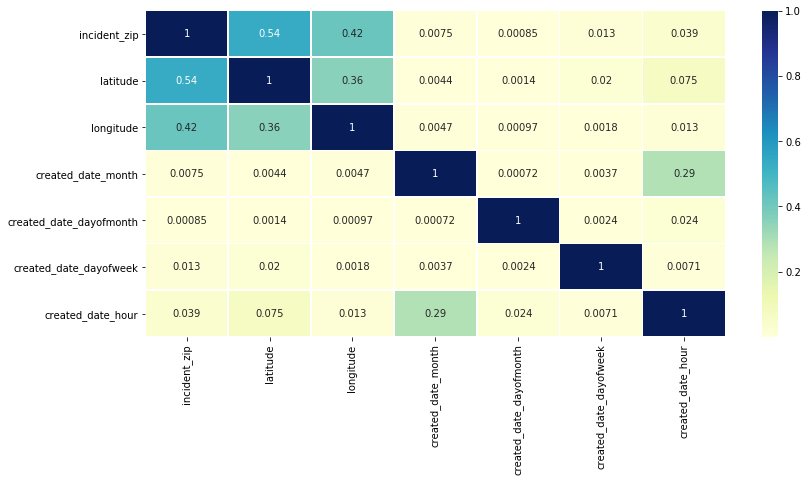

In [5]:
mask = np.zeros_like(abs(df.corr()), dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(13, 6))
sns.heatmap(abs(df.corr()), annot=True, linewidths=.5, cmap="YlGnBu")

In [5]:
def feature_importance_data(fited_model):
    feature_importances = pd.Series(fited_model.feature_importances_, index=X.columns)
    print(feature_importances)
    feature_importances.sort_values(inplace=True)
    return feature_importances.plot(kind='barh')

### Training/Test Data Seperation

In [9]:
from sklearn.model_selection import train_test_split

y = df.complaint_type
X = df.drop('complaint_type', axis=1)
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    shuffle=True, random_state=73)

## Random Forest

[ 0.47395406  0.47395522  0.47395869  0.47396332  0.47396564]
incident_zip                0.055365
latitude                    0.084299
longitude                   0.057332
created_date_month          0.149300
created_date_dayofmonth     0.000826
created_date_dayofweek      0.113346
created_date_hour           0.240988
borough_BRONX               0.054557
borough_BROOKLYN            0.003011
borough_MANHATTAN           0.044165
borough_QUEENS              0.028514
borough_STATEN ISLAND       0.020403
city_ARVERNE                0.000005
city_ASTORIA                0.000063
city_BAYSIDE                0.000966
city_BELLEROSE              0.000078
city_BREEZY POINT           0.000004
city_BRONX                  0.046456
city_BROOKLYN               0.004580
city_CAMBRIA HEIGHTS        0.000000
city_COLLEGE POINT          0.000020
city_CORONA                 0.007427
city_EAST ELMHURST          0.003585
city_ELMHURST               0.000257
city_FAR ROCKAWAY           0.000037
city_FLORAL P

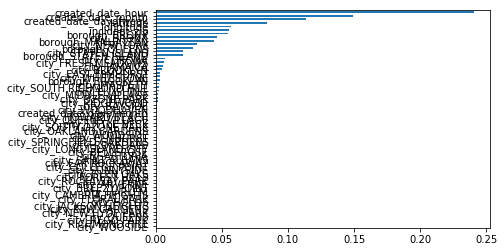

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


rf = RandomForestClassifier(n_estimators=500, max_depth=3, max_features=5, n_jobs=-1, random_state=73)
rf.fit(X,y)

scores = cross_val_score(rf,X,y, cv=5)
print(scores)

feature_importance_data(rf)

In [13]:
scores.mean()

0.47395938423462047

## Simplier Rnadom Forest model

[ 0.43608082  0.36966861  0.45718976  0.4513171   0.48319662]
incident_zip               0.021790
latitude                   0.045703
longitude                  0.015152
created_date_month         0.270067
created_date_dayofmonth    0.002422
created_date_dayofweek     0.090495
created_date_hour          0.534118
borough_BRONX              0.007685
borough_BROOKLYN           0.000786
borough_MANHATTAN          0.010157
borough_QUEENS             0.000692
borough_STATEN ISLAND      0.000934
dtype: float64


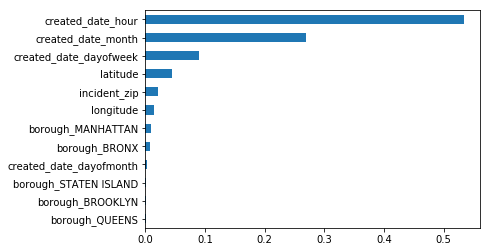

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


rf = RandomForestClassifier(n_estimators=100, max_depth=6, max_features=6, n_jobs=-1, random_state=73)
rf.fit(X,y)

scores = cross_val_score(rf,X,y, cv=5)
print(scores)

feature_importance_data(rf)

In [13]:
scores.mean()

0.43949058160915183

#### Grid Search

In [12]:
X.shape

(2046937, 61)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

parameters = {'max_depth': range(3,7), 'max_features': range(2,7)}
grid_search = GridSearchCV(estimator=rf_clf, param_grid=parameters, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_parameters=grid_search.best_estimator_.get_params()
best_parameters

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 6,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [18]:
grid_search.best_score_

0.5099664806587495

In [47]:
grid_search.predict_proba(X)

array([[ 0.05525573,  0.02303404,  0.05025309, ...,  0.05175179,
         0.04172401,  0.04423684],
       [ 0.02229384,  0.02655105,  0.04551605, ...,  0.02299005,
         0.03931414,  0.03903949],
       [ 0.05612724,  0.23549443,  0.0412015 , ...,  0.00918901,
         0.04526741,  0.01178076],
       ..., 
       [ 0.05392933,  0.07721549,  0.05074218, ...,  0.04953567,
         0.0461312 ,  0.03369183],
       [ 0.04904514,  0.05699792,  0.05409965, ...,  0.05631052,
         0.03836483,  0.04082074],
       [ 0.0564988 ,  0.06789091,  0.05047235, ...,  0.05248704,
         0.04270356,  0.036347  ]])

In [48]:
prob = grid_search.predict_proba(X)
for i, cls in enumerate(grid_search.classes_):
    df[cls] = prob[:,i]

In [118]:
# classes = grid_search.classes_
classes = ['Blocked Driveway', 'HEAT/HOT WATER', 'Illegal Parking', 'Noise',
       'Noise - Residential', 'PAINT/PLASTER',
       'Street Condition', 'Street Light Condition',
       'UNSANITARY CONDITION', 'Water System', 'Others']

In [102]:
grid_search.predict_proba(X_test)

array([[ 0.09644465,  0.11474345,  0.08961843, ...,  0.026131  ,
         0.02661764,  0.02865741],
       [ 0.01214331,  0.21999927,  0.00733172, ...,  0.00410453,
         0.10566566,  0.00693006],
       [ 0.05525573,  0.02303404,  0.05025309, ...,  0.05175179,
         0.04172401,  0.04423684],
       ..., 
       [ 0.09719729,  0.0054054 ,  0.05822412, ...,  0.02205897,
         0.00707167,  0.03597686],
       [ 0.06170144,  0.02052543,  0.05162176, ...,  0.05596932,
         0.02298999,  0.04895005],
       [ 0.05264817,  0.02146953,  0.05044165, ...,  0.04970449,
         0.04351479,  0.04399367]])

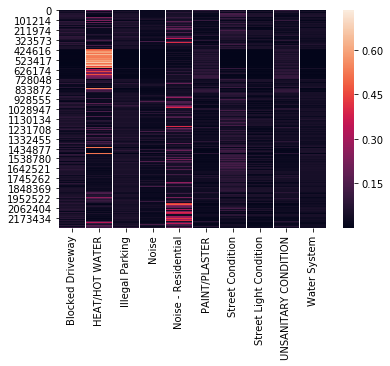

In [59]:
sns.heatmap(df[classes])

In [136]:
test_df = df[df['complaint_type']!='Others'].reset_index()
test_df = test_df.drop('index', axis=1)

def predict_proba_SR(case):
    for value, param in enumerate(test_df.columns[:9]):
        print('{:25}{}'.format(param, test_df.loc[case][value]))

    (test_df[classes].loc[case]).plot(kind='bar')
    plt.title("\nProbability of Service Request Type")

borough                  BRONX
incident_zip             10466
latitude                 40.889104556989224
longitude                -73.84219557851871
complaint_type           Blocked Driveway
created_date_month       9
created_date_dayofmonth  7
created_date_dayofweek   0
created_date_hour        15


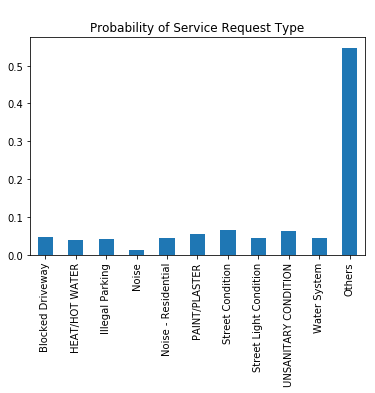

In [150]:
predict_proba_SR(13)

In [135]:
df[df['complaint_type']!='Others'].reset_index()


,index,borough,incident_zip,latitude,longitude,complaint_type,created_date_month,created_date_dayofmonth,created_date_dayofweek,created_date_hour,...,HEAT/HOT WATER,Illegal Parking,Noise,Noise - Residential,Others,PAINT/PLASTER,Street Condition,Street Light Condition,UNSANITARY CONDITION,Water System
0,2,BRONX,10453,40.852671,-73.910608,Blocked Driveway,11,9,0,3,...,0.235494,0.041202,0.035404,0.160464,0.354720,0.034372,0.015980,0.009189,0.045267,0.011781
1,15,QUEENS,11420,40.666895,-73.805453,Street Condition,4,28,1,17,...,0.022090,0.051433,0.020618,0.046522,0.517566,0.016124,0.132929,0.058017,0.021199,0.049193
2,17,BRONX,10461,40.842972,-73.853234,Blocked Driveway,9,13,6,21,...,0.016093,0.049714,0.016052,0.342388,0.368769,0.015042,0.030859,0.025119,0.021545,0.036862
3,20,BROOKLYN,11229,40.592868,-73.957156,Illegal Parking,7,13,0,1,...,0.018138,0.064374,0.044231,0.156739,0.465432,0.018727,0.061604,0.030731,0.028571,0.035313
4,21,MANHATTAN,10029,40.786883,-73.952307,Illegal Parking,7,28,1,10,...,0.027867,0.045563,0.048831,0.040951,0.606002,0.033130,0.069412,0.022521,0.042942,0.040513
5,22,BROOKLYN,11201,40.687708,-73.991663,Blocked Driveway,5,21,3,20,...,0.010442,0.082970,0.033692,0.186406,0.420885,0.011174,0.059348,0.045564,0.020594,0.039709
6,23,BROOKLYN,11228,40.605001,-74.013815,Illegal Parking,5,21,3,4,...,0.010337,0.065119,0.048699,0.143929,0.473612,0.017222,0.072953,0.035381,0.026146,0.036964
7,30,BRONX,10457,40.841497,-73.911136,UNSANITARY CONDITION,11,6,4,6,...,0.238716,0.042704,0.027088,0.104211,0.379527,0.041746,0.028454,0.010810,0.050229,0.018503
8,36,MANHATTAN,10016,40.745564,-73.971822,Illegal Parking,6,28,6,10,...,0.019779,0.055307,0.076841,0.113935,0.541736,0.014695,0.067954,0.008750,0.023569,0.042311
9,37,QUEENS,11432,40.720867,-73.803239,Blocked Driveway,7,1,2,19,...,0.021047,0.053726,0.022152,0.050309,0.551300,0.029312,0.078932,0.049502,0.040263,0.044051


## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import LinearSVM

logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
logreg.score(X_train, y_train)

0.47678400988153391

In [21]:
logreg.score(X_test, y_test)

0.47513064590149373

In [39]:
logreg.predict_proba(X)

array([[ 0.06792302,  0.07375083,  0.05051453, ...,  0.03776174,
         0.04811539,  0.03461721],
       [ 0.03844411,  0.07106147,  0.04554141, ...,  0.02837034,
         0.04198452,  0.03817442],
       [ 0.02424431,  0.19976376,  0.02604591, ...,  0.01859254,
         0.05804939,  0.01914885],
       ..., 
       [ 0.04571123,  0.05382901,  0.04199251, ...,  0.02619178,
         0.03869309,  0.02782001],
       [ 0.03242546,  0.03167503,  0.04188118, ...,  0.02322087,
         0.02980217,  0.03262647],
       [ 0.05925382,  0.03335478,  0.05063045, ...,  0.03109228,
         0.03386331,  0.03261295]])

In [34]:
logreg.classes_

array(['Blocked Driveway', 'HEAT/HOT WATER', 'Illegal Parking', 'Noise',
       'Noise - Residential', 'Others', 'PAINT/PLASTER',
       'Street Condition', 'Street Light Condition',
       'UNSANITARY CONDITION', 'Water System'], dtype=object)